In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
class Asteroid:
    def __init__(self, name, epoch, a_AU, e, i_deg, LAN_deg, argPeri_deg, meanAnom_deg):
        
        '''Class: Define an asteriod (or earth) using elements.
        Format agrees with the columns of GTOC4 dataset'''
        
        self.mu = 1.32712440018e+11  #km3/s2
        self.u_AU = 1.29597870691e+8 #km
        self.u_day = 86400           #seconds
        self.u_deg2rad = np.pi/180
        
        self.name  = name
        self.epoch = epoch #in MJD
        self.a     = a_AU*self.u_AU
        self.e     = e
        self.i     = self.u_deg2rad*i_deg
        self.LAN   = self.u_deg2rad*LAN_deg
        self.omega = self.u_deg2rad*argPeri_deg
        self.M0    = self.u_deg2rad*meanAnom_deg
        
        self.elements = (self.epoch, self.a, self.e, self.i, self.LAN, self.omega, self.M0)
        
        #cache the last calculated results
        self.last_epoch_meanAnom = None
        self.last_epoch_eccAnom = None
        self.last_epoch_trueAnom = None
        self.last_epoch_r_mag = None
        self.last_epoch_gamma = None
        self.last_epoch_v_mag = None
        self.last_epoch_r = None
        self.last_epoch_v = None
        
        
    def get_meanAnom(self, epoch):
        '''function returns mean anomaly
        Args:
            epoch (float): time, MJD
        Returns:
            (float): mean anomaly, radians (wrapped 0 .. 2 pi)
        '''
        
        if epoch == self.last_epoch_meanAnom:
            return self.last_meanAnom
        self.last_epoch_meanAnom = epoch
        
        
        meanAnom = self.M0 + np.sqrt(self.mu/self.a**3)*((epoch-self.epoch)*self.u_day)
        
        meanAnom = meanAnom % (2*np.pi)
        
        self.last_meanAnom = meanAnom
        
        return meanAnom
        
    def get_eccAnom(self, epoch, method=None,**kwargs):
        
        ''' Function calculates the eccentric anomaly. Uses scipy.optimize.root_scalar internally.
        Args:
            epoch (float): time, MJD
            method (str): method for root solving. optional, defaults to None. 
        Returns:
            (float): mean anomaly, radians (wrapped 0 .. 2 pi), if solution converged
        Errors:
            if convergence or solver fails, an error is raised. 
        '''
        
        if epoch == self.last_epoch_eccAnom:
            return self.last_eccAnom
        
        self.last_epoch_eccAnom = epoch

        def root_eccAnom(eccAnom, meanAnom, ecc):
            '''Returns the error in Kepler's equation, and its first and second derivatives'''
            
            error  = eccAnom - ecc*np.sin(eccAnom) - meanAnom
            deriv  = 1 - ecc*np.cos(eccAnom)
            deriv2 = ecc*np.sin(eccAnom)
            return error, deriv, deriv2

        #calculate mean anom
        meanAnom = self.get_meanAnom(epoch)
        
        #solve for true anom
        sol = opt.root_scalar(root_eccAnom, args=(meanAnom, self.e), bracket=(0, 2*np.pi), fprime2=True, method=method,**kwargs)

        if sol.converged:
            
            self.last_eccAnom = sol.root % (2*np.pi)
            
            return sol.root % (2*np.pi)
        else:
            print(f'Failed at: {str(self)} at epoch: {epoch}')
            print(sol)
            self.last_eccAnom = sol
            
            raise RuntimeError('Eccentric anomaly calculation failed:')
            
        
    def get_trueAnom(self, epoch, **kwargs):
        
        '''Returns true anomaly at epoch.
        Args:
            epoch (float): time, MJD
        Returns:
            (float): true anomaly, radians (wrapped 0 .. 2 pi)
        '''
        
        if epoch == self.last_epoch_trueAnom:
            return self.last_trueAnom
        self.last_epoch_trueAnom = epoch
        
        eccAnom = self.get_eccAnom(epoch, **kwargs)
        
        e = self.e
        
        trueAnom = (np.arctan( (1/np.sqrt((1-e)/(1+e))) * np.tan(eccAnom/2))) % 2*np.pi
        
        self.last_trueAnom = trueAnom
        
        return trueAnom
    
    def get_r_mag(self, epoch=None, trueAnom = None, **kwargs):
        
        '''Returns the distance from the sun. 
        If only epoch is provided, trueAnom is calculated.
        If trueAnom is provided, epoch has no effect
        Args:
            epoch (float): time, MJD
            trueAnom (float): true anomaly, rad
            
        Returns:
            (float): distance from sun, km
        '''
        
        if epoch == self.last_epoch_r_mag:
            return self.last_r_mag
        self.last_epoch_r_mag = epoch
        
        if trueAnom is None:
            trueAnom = self.get_trueAnom(epoch,**kwargs)
        
        r_mag = self.a*(1-self.e**2)/(1+self.e*np.cos(trueAnom))
        
        self.last_r_mag = r_mag
        
        return r_mag
        
    def get_gamma(self, epoch, trueAnom = None,**kwargs):
        '''Returns flight path angle gamma. 
        If only epoch is provided, trueAnom is calculated.
        If trueAnom is provided, epoch has no effect
        Args:
            epoch (float): time, MJD
            trueAnom (float): true anomaly, rad
            
        Returns:
            (float): flight path angle, rad
        '''
        
        if epoch == self.last_epoch_gamma:
            return self.last_gamma
        self.last_epoch_gamma = epoch
        
        if trueAnom is None:
            trueAnom = self.get_trueAnom(epoch,**kwargs)
            
        gamma = np.arctan((self.e*np.sin(trueAnom))/(1+self.e*np.cos(trueAnom)))
        
        self.last_gamma = gamma
        
        return gamma
        
        
    def get_v_mag(self, epoch, trueAnom = None,**kwargs):
        '''Returns helio-centric speed of asteroid. 
        If only epoch is provided, trueAnom is calculated.
        If trueAnom is provided, epoch has no effect
        Args:
            epoch (float): time, MJD
            trueAnom (float): true anomaly, rad
            
        Returns:
            (float): speed of asteroid in orbit about Sun, km/s
        '''
        
        if epoch == self.last_epoch_v_mag:
            return self.last_v_mag
        self.last_epoch_v_mag = epoch

        r = self.get_r_mag(epoch, trueAnom,**kwargs)
        
        v = np.sqrt(2*self.mu/r - self.mu/self.a)

        self.last_v_mag = v
        
        return v
    
    def get_r(self, epoch, trueAnom=None,**kwargs):
        
        '''Returns position vector relative to Sun. 
        If only epoch is provided, trueAnom is calculated.
        If trueAnom is provided, epoch has no effect
        Args:
            epoch (float): time, MJD
            trueAnom (float): true anomaly, rad
            
        Returns:
            (numpy.array): position vector, km
        '''
        
        if epoch == self.last_epoch_r:
            return self.last_r
        self.last_epoch_r = epoch
            
            
        if trueAnom is None:
            trueAnom = self.get_trueAnom(epoch,**kwargs)
            
        r = self.get_r_mag(epoch, trueAnom, **kwargs)
        
        costo = np.cos(trueAnom + self.omega)
        sinto = np.sin(trueAnom + self.omega)
        
        x = r*(costo*np.cos(self.LAN) - sinto*np.cos(self.i)*np.sin(self.LAN))
        y = r*(costo*np.sin(self.LAN) + sinto*np.cos(self.i)*np.cos(self.LAN))
        z = r*(sinto*np.sin(self.i))
        
        r_vec = np.array([x,y,z])
        
        self.last_r = r_vec
        
        return r_vec
    
    def get_v(self, epoch, trueAnom=None, **kwargs):
        '''Returns heliocentric velocity vector. 
        If only epoch is provided, trueAnom is calculated.
        If trueAnom is provided, epoch has no effect
        Args:
            epoch (float): time, MJD
            trueAnom (float): true anomaly, rad
            
        Returns:
            (numpy.array): heliocentric velocity vector, km/s
        '''
        
        if epoch == self.last_epoch_v:
            return self.last_v
        
        self.last_epoch_v = epoch
        
        if trueAnom is None:
            trueAnom = self.get_trueAnom(epoch,**kwargs)
            
        v = sef.get_v_mag(epoch, trueAnom)
        
        gamma = self.get_gamma(epoch, trueAnom)
        
        costog = np.cos(trueAnom + self.omega - gamma)
        sintog = np.sin(trueAnom + self.omega - gamma)
        
        vx = v*(-sintog*np.cos(self.LAN) - costog*np.cos(self.i)*np.sin(self.LAN))
        vy = v*(-sintog*np.sin(self.LAN) + costog*np.cos(self.i)*np.cos(self.LAN))
        vz = v*(costog*np.sin(self.i))
        
        v_vec = np.array([vx, vy, vz])
        
        self.last_v = v_vec
        
        return v_vec
    
    def dist_to(self, other, epoch,**kwargs):
        
        '''Returns distance vector to the other asteroid. 
        Uses the other objects .get_r(epoch) function to get its position
        
        Args:
            other (Asteroid): other asteroid object
            epoch (float): time, MJD
            
        Returns:
            (numpy.array): (r_other-r_self) vector, km
        '''
        
        r  = self.get_r(epoch,**kwargs)
        rp = other.get_r(epoch,**kwargs)
        
        return rp-r
    
    def dist_to_mag(self, other, epoch, **kwargs):
        
        '''Returns the magnitude of the distance to the other asteroid
        Uses the other objects .get_r(epoch) function to get its position
        
        Args: 
            other (Asteroid): other asteroid object
            epoch (float): time, MJD
        Returns:
            (float): distance between objects, km
        '''
        
        dr = self.dist_to(other, epoch, **kwargs)
        
        return np.linalg.norm(dr)
        
        
    def details(self):
        '''String output of orbital elements of the asteroid
        Returns: 
            (str): asteroid details
        '''

        out  = f'*Asteroid {self.name}*'
        out += f'\n  Epoch0 (MJD)  : {self.epoch}'
        out += f'\n  a (AU)        : {self.a/self.u_AU}'
        out += f'\n  e (deg)       : {self.e/self.u_deg2rad}'
        out += f'\n  i (deg)       : {self.i/self.u_deg2rad}'
        out += f'\n  LAN (deg)     : {self.LAN/self.u_deg2rad}'
        out += f'\n  argPeri (deg) : {self.omega/self.u_deg2rad}'
        out += f'\n  meanAnom (deg): {self.M0/self.u_deg2rad}'
        
        return out
    
    def __repr__(self):
        
        out = f'Asteroid {self.name}'
        
        return out

## Example usage

In [3]:
# load data
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']
df.head()

,Name,Epoch,a,e,i,LAN,omega,M0
0,'1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,'1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,'1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238
3,'2061',54800.0,2.264953,0.537119,3.770822,207.654108,156.432028,46.995497
4,'2135',54800.0,1.599572,0.503268,23.054312,191.262849,290.838892,256.724981


In [4]:
# load all asteroids into a list 
asteroids = [None,]*len(df)

for i in range(len(df)):
    asteroids[i] = Asteroid(*tuple(df.loc[i].values))

In [5]:
asteroids;

In [6]:
#printing
print(asteroids[0])

Asteroid '1580'


In [7]:
print(asteroids[0].details())

*Asteroid '1580'*
  Epoch0 (MJD)  : 54800.0
  a (AU)        : 2.1968033753931695
  e (deg)       : 27.942183758436297
  i (deg)       : 52.09079390385544
  LAN (deg)     : 62.324795115974354
  argPeri (deg) : 159.53983855505257
  meanAnom (deg): 3.5216868177911254


In [27]:
# define epochs in MJD
epoch = 54801
# for simplicity
ast1 = asteroids[1]
ast2 = asteroids[2]

In [8]:
# you can get the position
ast1.get_r(epoch = 54810)

array([-4.48517621e+07, -1.45442070e+08, -3.57391240e+07])

In [28]:
# or the distance from the sun (in km)
ast2.get_r_mag(epoch = epoch)

165031288.8500806

In [12]:
# or other parameters
# all angles are in radians
print(f'mean anom: {ast1.get_meanAnom(epoch)}')
print(f'ecc  anom: {ast1.get_eccAnom(epoch)}')
print(f'true anom: {ast1.get_trueAnom(epoch)}')

mean anom: 0.06801721260631702
ecc  anom: 0.13239607808785522
true anom: 0.3534097304794925


In [13]:
# you can also use a different method, if you provide the necessary details
ast1.get_trueAnom(epoch, method='secant', x0=5, x1=10)

0.3534097304794925

In [14]:
# compute vector to get from one asteroid to another
# returns (ast_2.r - ast_1.r)
ast1.dist_to(ast2, epoch)

array([-5.91266524e+07,  2.34591594e+08,  1.02893535e+07])

In [15]:
# compute distance (magnitude) between two asteroids
# returns norm(ast_2.r - ast_1.r)
ast1.dist_to_mag(ast2, epoch)

242146748.72595546

In [16]:
# create a list of distanes from 0th asteroid to all other asteroids, and print the minimum
dists = [(asteroids[i].name, asteroids[0].dist_to_mag(asteroids[i],epoch)) for i in range(len(asteroids)) if i is not 0]
ast, dist = min(dists, key = lambda t: t[1])
print(f'Closest to {ast}, dist = {dist} km')

Closest to '2008JP2, dist = 11757868.069377521 km


In [17]:
# same for a range of times
times = np.linspace(54800, 55100, 11)
AU = 1.29597870691e+8

for epoch in times:
    dists = [(asteroids[i].name, asteroids[0].dist_to_mag(asteroids[i],epoch)) for i in range(len(asteroids)) if i is not 0]
    ast, dist = min(dists, key = lambda t: t[1])
    print(f'Epoch {epoch}: Closest to {ast}; dist = {dist/AU} AU')
    

Epoch 54800.0: Closest to '2008JP2; dist = 0.10434251785611183 AU
Epoch 54830.0: Closest to '164121'; dist = 0.41435676182687525 AU
Epoch 54860.0: Closest to '164121'; dist = 0.7572130411988243 AU
Epoch 54890.0: Closest to '55532'; dist = 0.4733260638104809 AU
Epoch 54920.0: Closest to '2005NG5; dist = 0.7732578504836853 AU
Epoch 54950.0: Closest to '2002BK2; dist = 0.5020424565951668 AU
Epoch 54980.0: Closest to '2006DQ6; dist = 0.2580627304770215 AU
Epoch 55010.0: Closest to '2003SN2; dist = 0.12696069959063888 AU
Epoch 55040.0: Closest to '162979'; dist = 0.28395450009894535 AU
Epoch 55070.0: Closest to '2008GV'; dist = 0.42775914936465936 AU
Epoch 55100.0: Closest to '2008GV'; dist = 0.2862552612104748 AU


In [22]:
# image of distances between asteroids, at a given epoch
N = len(asteroids)

dists = np.zeros([N,N])
AU = 1.29597870691e+8
epoch = 54800

for i in range(N):
    for j in range(N):
        if j>i:
            d = asteroids[i].dist_to_mag(asteroids[j], epoch)/AU
            dists[i,j] = d
            dists[j,i] = d
            
# pretty efficient because the positions from the last epoch that we calculated are stored 
# within the object and can be quickly retrived. Means the positions are only calculated once for each asteroid
# the gridded distance calcs need to be done on the upper-triangular space, and takes a few seconds on python

Text(0.5, 1.0, 'Distance (AU) between asteroids at 54800MJD')

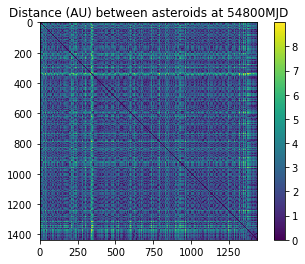

In [24]:
plt.imshow(dists)
plt.colorbar()
plt.title(f'Distance (AU) between asteroids at {epoch}MJD')

In [25]:
# therefore we can see that the minimum distance between two asteroids at epoch is about 0.005 AU
dists[dists>0].min()

0.004906130530691205